# Load Libaries and Functions

In [16]:
#Homemade Functions
from functions.functions_analysis import *
from functions.Path_combine_function import *
from functions.plot_functions import *
from functions.Preproc_functions import *

import matplotlib.pyplot as plt
import nibabel as nib

import pickle

import numpy as np

import pickle
from pathlib import Path
import time


import dipy
from dipy.segment.tissue import TissueClassifierHMRF
from dipy.io.image import load_nifti_data

import ants 

Recommended Approach:
1. Create the mask first at the original high resolution.

2. Then downscale the mask to match the DTI resolution.
Why?
    - ✅ Preserves detail – Creating the mask at full resolution ensures it captures finer anatomical features.
    - ✅ Avoids information loss – Downscaling first may blur important structures, making segmentation less accurate.
    - ✅ Consistency – Once you have a high-quality mask, downscaling it ensures alignment with the downscaled RARE and DTI images.

Steps:
1. Segment WM + GM from the high-resolution RARE image.
2. Downscale the mask to match the resolution of the DTI images.
3. Apply the mask to the DTI data.

In [ ]:
### Load in Data 
RARE_combined_masked_rotated , RARE_Affine_all = nib.load("C:/DTI_SC/humanSC_400h/Combined_Data/RARE_combined_trans_masked_rotated.nii.gz").get_fdata(), nib.load("C:/DTI_SC/humanSC_400h/Combined_Data/RARE_combined_trans_masked_rotated.nii.gz")

DTI_combined_preproc_trans_masked_rotated , DTI_Affine_all = nib.load("C:/DTI_SC/humanSC_400h/Combined_Data/DTI_combined_preproc_trans_masked_rotated.nii.gz").get_fdata(), nib.load("C:/DTI_SC/humanSC_400h/Combined_Data/DTI_combined_preproc_trans_masked_rotated.nii.gz")


## Segmentation Simon


In [2]:
SIMON_wm_mask_path = "C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/wm.nii.gz"
SIMON_wm_mask, wm_affine =  nib.load(SIMON_wm_mask_path).get_fdata() , nib.load(SIMON_wm_mask_path).affine
SIMON_wm_mask.shape

SIMON_struc_all_path = "C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/stitched_spinal_cord.nii.gz"
SIMON_struc_all , struc_affine = nib.load(SIMON_struc_all_path).get_fdata() , nib.load(SIMON_struc_all_path).affine
SIMON_struc_all.shape


(348, 296, 1919)

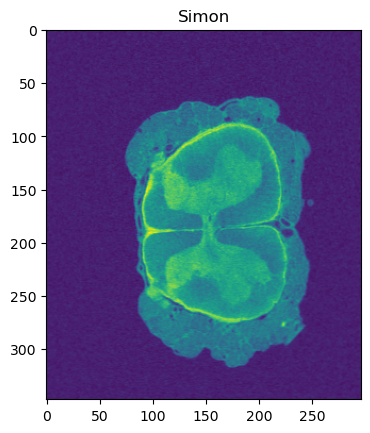

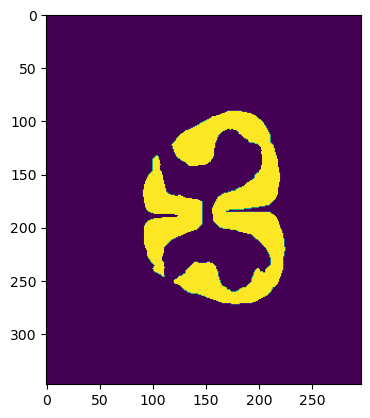

NameError: name 'RARE_combined_masked_rotated' is not defined

In [3]:
z_axis = 200
plt.imshow(SIMON_struc_all[:,:,z_axis])
plt.title("Simon")
plt.show()

plt.imshow(SIMON_wm_mask[:,:,z_axis])
plt.show()

plt.imshow(RARE_combined_masked_rotated[:,:,z_axis])
plt.show()

# Unsupervised Clustering for Segmentation

In [58]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.ndimage import binary_closing, binary_fill_holes, gaussian_filter

def normalize_intensity(image_array):
    """
    Normalize the intensity of the image to have zero mean and unit variance.
    """
    norm_image = (image_array - np.mean(image_array)) / np.std(image_array)
    return norm_image

def segment_wm_gm(image_array, method='kmeans',  mask = None):
    """
    Segment white matter (WM) and gray matter (GM) using clustering.
    """
    # Mask the image to reduce computation
    if mask != None:
        masked_image = image_array[mask].flatten().reshape(-1, 1)
    else:
        masked_image = image_array.flatten().reshape(-1, 1)

    # Choose clustering method
    if method == 'kmeans':
        model = KMeans(n_clusters=3 )
        labels = model.fit_predict(masked_image)
    elif method == 'gmm':
        model = GaussianMixture(n_components=3)
        labels = model.fit_predict(masked_image)

    # Map the labels back to the original image shape
    segmented = labels.reshape(image_array.shape)

    return segmented


# Step 5: Post-Processing
def refine_segmentation(segmentation):
    """
    Refine the segmentation using Gaussian smoothing and morphology.
    """
    refined_segmentation = gaussian_filter(segmentation.astype(float), sigma=10)
    refined_segmentation = refined_segmentation > 0.5  # Binarize
    return refined_segmentation

In [649]:
import random
random.seed(666)

data = ants.image_read("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated_BFC_corrected20.nii.gz")
data_numpy = data.numpy()
data_numpy_subset = data_numpy[:,:,0:500]


#Segment kmean
wmgm_mask_Kmeans = segment_wm_gm(data_numpy_subset, method= "kmeans")


data_t2_raw = ants.image_read("Combined_Data/RARE_combined.nii.gz")
data_t2_raw_numpy = data_t2_raw.numpy()
data_t2_raw_numpy_subset = data_t2_raw_numpy[:,:,0:500]

#Segment kmean
wmgm_mask_Kmeans_raw = segment_wm_gm(data_t2_raw_numpy_subset, method= "kmeans")

mat_swapped = np.where(wmgm_mask_Kmeans_raw == 0, 2, np.where(wmgm_mask_Kmeans_raw == 2, 0, wmgm_mask_Kmeans_raw))
mat_swapped2 = np.where(mat_swapped == 0, 1, np.where(mat_swapped == 1, 0, mat_swapped))

In [ ]:
mat_swapped = np.where(wmgm_mask_Kmeans_raw == 0, 2, np.where(wmgm_mask_Kmeans_raw == 2, 0, wmgm_mask_Kmeans_raw))
mat_swapped2 = np.where(mat_swapped == 0, 1, np.where(mat_swapped == 1, 0, mat_swapped))

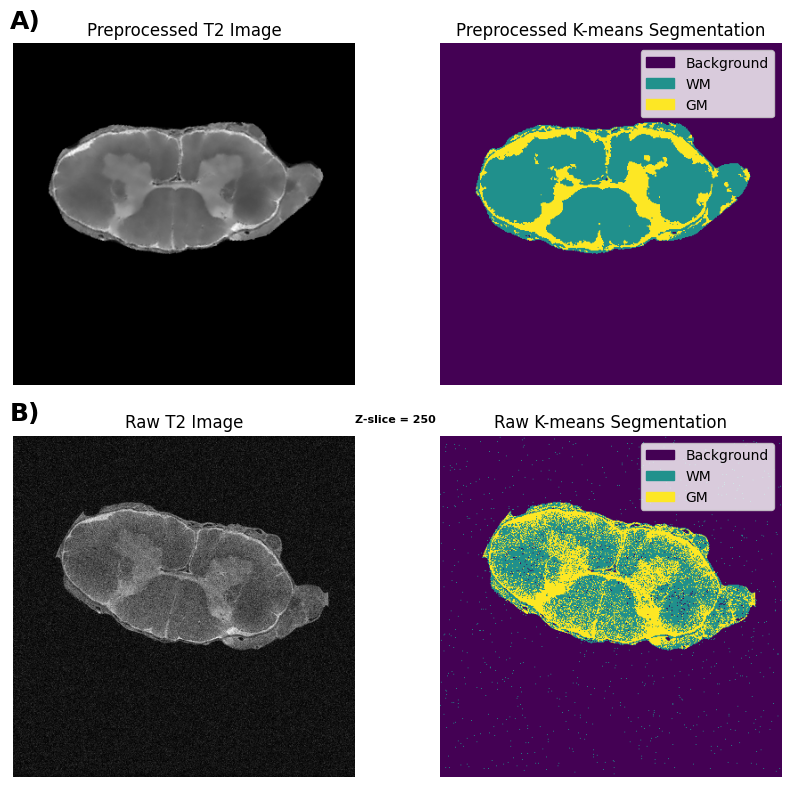

In [ ]:
z = 250
plt.figure(figsize=(8, 8))

plt.subplot(2,2,2)
im = plt.imshow(wmgm_mask_Kmeans[:,:,z])
plt.axis('off')
plt.title("Preprocessed K-means Segmentation")

# Create legend for KMeans classes
import matplotlib.patches as mpatches
classes = ["Background","WM", "GM"]
class_indices = [0, 1, 2]
colors = [im.cmap(im.norm(val)) for val in class_indices]
patches = [mpatches.Patch(color=colors[i], label=classes[i]) for i in range(len(classes))]
plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc= 'upper right')

plt.subplot(2,2,1)
plt.imshow(data_numpy_subset[:,:,z], cmap = "gray")
plt.gca().text(-0.01, 1.1, "A)", transform=plt.gca().transAxes,
               fontsize=18, fontweight='bold', va='top')
plt.axis('off')
plt.title(f"Preprocessed T2 Image")
plt.tight_layout()


plt.subplot(2,2,4)
im = plt.imshow(np.rot90(wmgm_mask_Kmeans_raw[:,:,z]))
plt.gca().invert_yaxis()
plt.axis('off')
plt.title("Raw K-means Segmentation")

# Create legend for KMeans classes
import matplotlib.patches as mpatches
classes = [ "Background","WM", "GM"]
class_indices = [0, 1, 2]
colors = [im.cmap(im.norm(val)) for val in class_indices]
patches = [mpatches.Patch(color=colors[i], label=classes[i]) for i in range(len(classes))]
plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc= 'upper right')

plt.subplot(2,2,3)
plt.imshow(np.rot90(data_t2_raw_numpy_subset[:,:,z]), cmap = "gray")
plt.gca().text(-0.01, 1.1, "B)", transform=plt.gca().transAxes,
               fontsize=18, fontweight='bold', va='top')
plt.gca().invert_yaxis()
plt.gca().text(1, 1.05, f"Z-slice = {z}", transform=plt.gca().transAxes,
               fontsize = 8, fontweight='bold', va='center')
plt.axis('off')
plt.title(f"Raw T2 Image")



plt.tight_layout()
plt.savefig("figures/k_means_segmentation_raw_and_processed.svg", dpi = 1000)
plt.show()

# Dipy Segmentation

In [212]:
def dipy_segmentation(data, beta_array: "array", nclass, output_path = None):
    """
    Suggested params 
    **Data:** Raw volumetric image data as a ndarray.
    **beta_array:** ndarray np.arange(0.1, 0.2 , 0.05)
    **nlass:** number of clusters/classes to segment (int)
    """
    Segment_dict = {}


    for beta in beta_array:
        # Now we will define the other two parameters for the segmentation algorithm. 
        # We will segment three classes, namely corticospinal fluid (CSF), white matter (WM) and gray matter (GM).
        nclass = nclass

        #Then, the smoothness factor of the segmentation. Good performance is achieved with values between 0 and 0.5.
        beta = beta

        t0 = time.time()

        #final_segmentation : ndarray, 3D final refined segmentation containing all tissue types.
        # PVE : ndarray, 3D probability map of each tissue type.

        hmrf = TissueClassifierHMRF()

        initial_segmentation, final_segmentation, PVE = hmrf.classify(data, nclass, beta)

        t1 = time.time()
        total_time = t1-t0
        print('Total time:' + str(total_time))


        Segment_dict[str(beta)] = [initial_segmentation, final_segmentation, PVE]


    # Save to a pickle file
    if output_path is not None:
        with open(output_path +'.pkl', 'wb') as f:
            pickle.dump(Segment_dict, f)



    
    return(Segment_dict)


In [416]:
data = ants.image_read("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated_BFC_corrected20.nii.gz")
data_numpy = data.numpy()
data_numpy_subset = data_numpy[:,:,200:300]

In [417]:
Segment_dict_2class_many_beta = dipy_segmentation(data = data_numpy_subset,  beta_array= np.arange(0.1,0.81,0.1), nclass= 2, output_path= 'data/Segment/DIPY_Seg_BETA.05_.8_full_preproc_nclass2Test')

>> Iteration: 0
>> Iteration: 1
>> Iteration: 2
>> Iteration: 3
>> Iteration: 4
>> Iteration: 5
>> Iteration: 6
>> Iteration: 7
>> Iteration: 8
>> Iteration: 9
>> Iteration: 10
>> Iteration: 11
>> Iteration: 12
>> Iteration: 13
>> Iteration: 14
>> Iteration: 15
>> Iteration: 16
>> Iteration: 17
>> Iteration: 18
>> Iteration: 19
>> Iteration: 20
>> Iteration: 21
>> Iteration: 22
>> Iteration: 23
>> Iteration: 24
>> Iteration: 25
>> Iteration: 26
>> Iteration: 27
>> Iteration: 28
>> Iteration: 29
>> Iteration: 30
>> Iteration: 31
>> Iteration: 32
>> Iteration: 33
>> Iteration: 34
>> Iteration: 35
>> Iteration: 36
>> Iteration: 37
>> Iteration: 38
>> Iteration: 39
>> Iteration: 40
>> Iteration: 41
>> Iteration: 42
>> Iteration: 43
>> Iteration: 44
>> Iteration: 45
>> Iteration: 46
>> Iteration: 47
Total time:299.80413842201233
>> Iteration: 0
>> Iteration: 1
>> Iteration: 2
>> Iteration: 3
>> Iteration: 4
>> Iteration: 5
>> Iteration: 6
>> Iteration: 7
>> Iteration: 8
>> Iteration: 9
>> I

In [ ]:
Segment_dict = dipy_segmentation(data = data_numpy_subset,  beta_array= np.arange(0.05,0.151,0.05), nclass= 2, output_path= 'data/Segment/DIPY_Seg_full_preproc_nclass2Test')

In [ ]:
z = 50

# pick only 2nd, 4th, and last keys
keys = list(Segment_dict_2class_many_beta.keys())
selected_keys = [keys[0],keys[2], keys[4], keys[-2]]  # 0-based indexing


fig, axes = plt.subplots(len(selected_keys), 2, figsize=(8, 3 * len(selected_keys)))
for i, key in enumerate(selected_keys):
    beta = key
    segs = Segment_dict_2class_many_beta[beta]

    axes[i,0].imshow(segs[1][:, :, z])



    axes[i, 0].axis('off')
    axes[i, 1].imshow(data_numpy_subset[:, :, z], cmap="gray")
    if i == 0:
        axes[i, 1].set_title(f"Raw Image")
        axes[i, 0].set_title(f"Segmentation, beta={float(beta):.2f}")
    else:
        axes[i, 0].set_title(f"beta={float(beta):.2f}")

    axes[i, 1].axis('off')

axes[0,0].text(-0.01, 1.12, "C)", transform=axes[0,0].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='center')


fig.text(.5,.47, f"Z-slice = {z}", fontsize=12, fontweight='bold', va='center', ha='center')
plt.suptitle("HMRF-EM Segmentation", fontsize=22, fontweight='bold')
plt.tight_layout()
plt.savefig("figures/HMRF_EM_Segmentation_2class.svg", dpi=300)
plt.show()

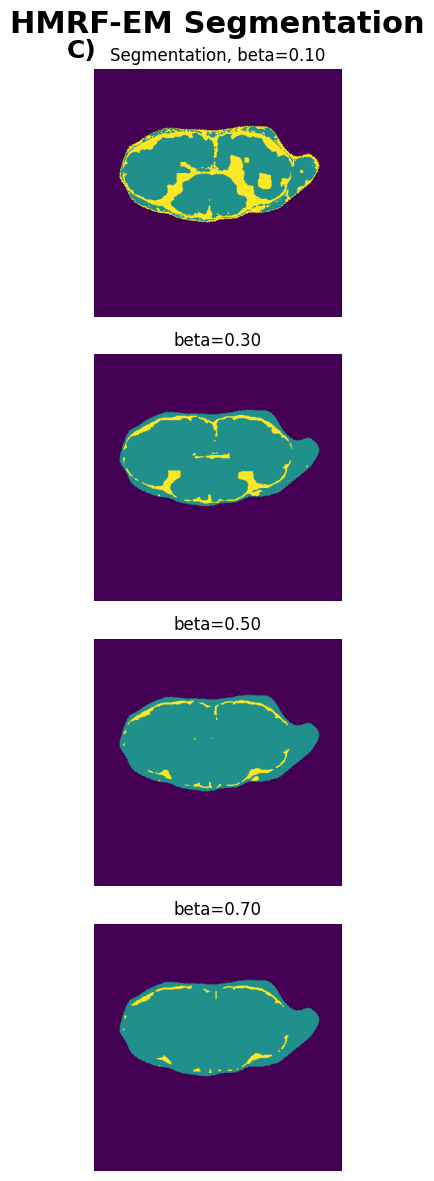

In [689]:
z = 50

# pick only 1st, 3rd, 5th, and 2nd-to-last keys
keys = list(Segment_dict_2class_many_beta.keys())
selected_keys = [keys[0], keys[2], keys[4], keys[-2]]

# now only 1 column (segmentation)
fig, axes = plt.subplots(len(selected_keys), 1, figsize=(6, 3 * len(selected_keys)))

# if only one row, axes is not a list → fix
if len(selected_keys) == 1:
    axes = [axes]

for i, key in enumerate(selected_keys):
    beta = key
    segs = Segment_dict_2class_many_beta[beta]

    axes[i].imshow(segs[1][:, :, z])
    axes[i].axis('off')

    # Titles
    if i == 0:
        axes[i].set_title(f"Segmentation, beta={float(beta):.2f}")
    else:
        axes[i].set_title(f"beta={float(beta):.2f}")

# Add label "C)" on the first subplot
axes[0].text(-0.05, 1.12, "C)", transform=axes[0].transAxes,
             fontsize=18, fontweight='bold', va='top', ha='center')

# Add Z-slice info as global text
#fig.text(.5, .47, f"Z-slice = {z}", fontsize=12, fontweight='bold', va='center', ha='center')

plt.suptitle("HMRF-EM Segmentation", fontsize=22, fontweight='bold')
plt.tight_layout()
plt.savefig("figures/HMRF_EM_Segmentation_2class_only_segmentations.svg", dpi=300)
plt.show()


## Dice-score evaluation of HMRF-EM

In [369]:
# Load Data
data_labeled = np.load("Simon FODs/hsc2_structural_data_and_gmwm_masks/resized_masked_gibbs_denoised_stitched_spinal_cord_200_200.npy")
labels_gm = np.load("Simon FODs/hsc2_structural_data_and_gmwm_masks/slices_gm_mask_200_200.npy")  # Replace with actual paths
labels_wm = np.load("Simon FODs/hsc2_structural_data_and_gmwm_masks/slices_wm_mask_200_200.npy")  # Replace with actual paths


labels_gm_wm = np.where(labels_gm == 1, 2, np.where(labels_wm == 1,1 ,0) )


labels_gm_wm_subset = labels_gm_wm[800:850,:,:].squeeze()
data_labeled_subset = data_labeled[800:850,:,:].squeeze()

data_labeled_subset_masked, mask = median_otsu(data_labeled_subset, median_radius= 4 , numpass = 4)

In [341]:
Segment_dict_prelabel = dipy_segmentation(data = data_labeled_subset_masked,  beta_array= np.arange(0.05,0.8,0.1), nclass= 2, output_path= 'data/Segment/DIPY_PRELABEL_Simon_Seg_full_preproc_nclass2Test')

>> Iteration: 0
>> Iteration: 1
>> Iteration: 2
>> Iteration: 3
>> Iteration: 4
>> Iteration: 5
>> Iteration: 6
>> Iteration: 7
>> Iteration: 8
>> Iteration: 9
>> Iteration: 10
>> Iteration: 11
>> Iteration: 12
>> Iteration: 13
>> Iteration: 14
>> Iteration: 15
>> Iteration: 16
>> Iteration: 17
>> Iteration: 18
>> Iteration: 19
>> Iteration: 20
>> Iteration: 21
>> Iteration: 22
>> Iteration: 23
>> Iteration: 24
>> Iteration: 25
Total time:15.167496919631958
>> Iteration: 0
>> Iteration: 1
>> Iteration: 2
>> Iteration: 3
>> Iteration: 4
>> Iteration: 5
>> Iteration: 6
>> Iteration: 7
>> Iteration: 8
>> Iteration: 9
>> Iteration: 10
>> Iteration: 11
>> Iteration: 12
>> Iteration: 13
>> Iteration: 14
>> Iteration: 15
>> Iteration: 16
>> Iteration: 17
>> Iteration: 18
>> Iteration: 19
>> Iteration: 20
>> Iteration: 21
>> Iteration: 22
>> Iteration: 23
>> Iteration: 24
>> Iteration: 25
>> Iteration: 26
>> Iteration: 27
>> Iteration: 28
>> Iteration: 29
>> Iteration: 30
>> Iteration: 31
Tota

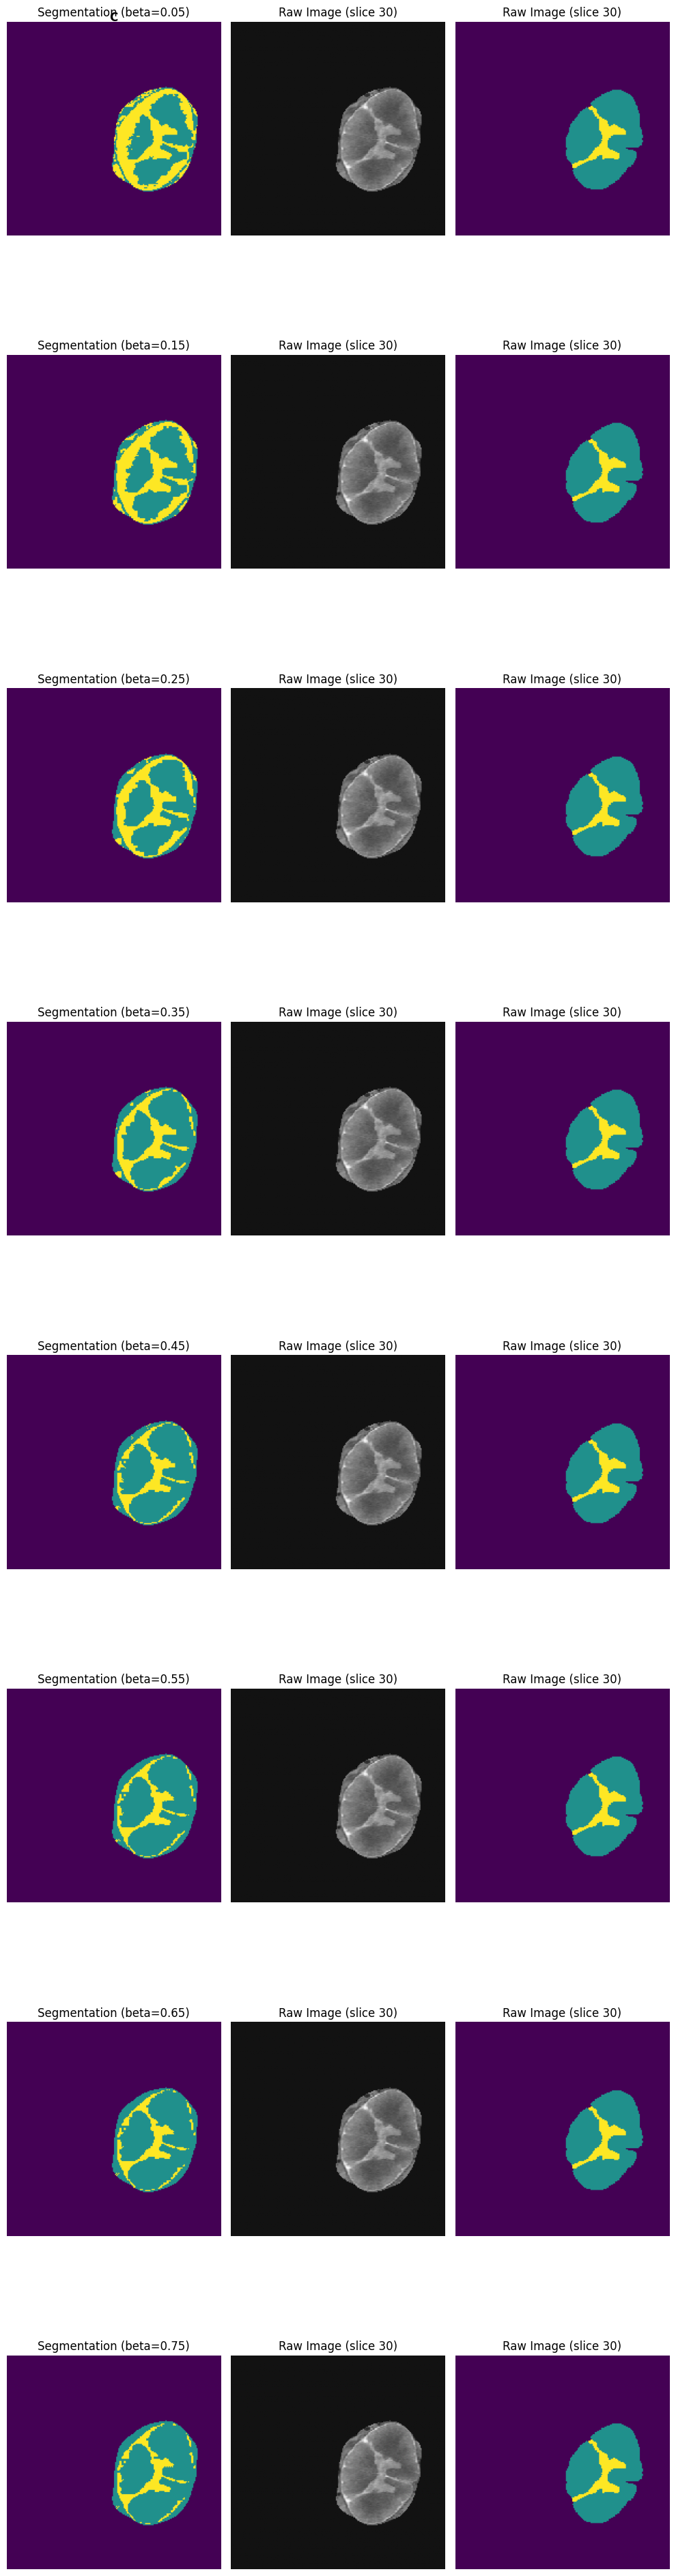

In [ ]:
z = 30

fig, axes = plt.subplots(len(Segment_dict_prelabel), 3, figsize=(10, 5 * len(Segment_dict_prelabel)))
for i, (beta, segs) in enumerate(Segment_dict_prelabel.items()):
    im = axes[i, 0].imshow(segs[1][z, :, :])
    #fig.colorbar(im, ax=axes[i, 0])
    axes[i, 0].set_title(f"Segmentation (beta={float(beta):.2f})")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(data_labeled_subset_masked[z, :, :], cmap="gray")
    axes[i, 1].set_title(f"Raw Image (slice {z})")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(labels_gm_wm_subset[z, :, :])
    axes[i, 2].set_title(f"Raw Image (slice {z})")
    axes[i, 2].axis('off')

axes[0,0].text(0.5, 1.05, "C", transform=axes[0,0].transAxes,
            fontsize=12, fontweight='bold', va='top', ha='center')
plt.tight_layout()

In [371]:
import numpy as np
from typing import Iterable, Optional, Dict, Any

def dice_labelmaps_3d(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    labels: Optional[Iterable[int]] = None,
    ignore_background: bool = True,
    smooth: float = 1e-6,
    per_slice: bool = False,     # if True, also return Dice per Z-slice
) -> Dict[str, Any]:
    """
    Dice for integer label maps of shape (Z, X, Y).

    Returns:
      - per-class Dice in a dict (keys 'label=k')
      - 'mean' Dice (average over chosen labels)
      - if per_slice=True: adds 'per_slice' dict with arrays of shape (Z,) per label
    """
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape (Z, X, Y).")
    if y_true.ndim != 3:
        raise ValueError("Expected 3D arrays shaped (Z, X, Y).")

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Select labels to score
    if labels is None:
        labels = np.unique(np.concatenate([np.unique(y_true), np.unique(y_pred)]))
        if ignore_background:
            labels = [int(l) for l in labels if l != 0]
    else:
        labels = list(labels)

    out: Dict[str, Any] = {}
    dices = []

    # Precompute if per-slice needed
    Z = y_true.shape[0]
    if per_slice:
        per_slice_dict: Dict[int, np.ndarray] = {k: np.zeros(Z, dtype=float) for k in labels}

    for k in labels:
        t = (y_true == k)
        p = (y_pred == k)
        inter = np.count_nonzero(t & p)
        denom = t.sum() + p.sum()
        d = (2.0 * inter + smooth) / (denom + smooth)
        out[f"label={k}"] = float(d)
        dices.append(d)

        if per_slice:
            # Slice-wise Dice along Z
            ts = t.reshape(Z, -1)
            ps = p.reshape(Z, -1)
            inter_s = np.count_nonzero(ts & ps, axis=1)
            denom_s = ts.sum(axis=1) + ps.sum(axis=1)
            per_slice_dict[k] = (2.0 * inter_s + smooth) / (denom_s + smooth)

    out["mean"] = float(np.mean(dices)) if len(dices) > 0 else float("nan")
    if per_slice:
        out["per_slice"] = per_slice_dict
    return out


In [310]:
test_tp = np.where(Segment_dict_prelabel["0.1"][1] ==  labels_gm_wm_subset.squeeze(), 1, 0)

In [372]:
dice_scores = {}
for beta, segs in Segment_dict_prelabel.items():
    dice_scores[beta] = dice_labelmaps_3d(
        y_true=labels_gm_wm_subset,
        y_pred= segs[1],
        ignore_background=True
    )
dice_scores


{'0.05': {'label=1': 0.7056487463703028,
  'label=2': 0.37734143751622706,
  'mean': 0.541495091943265},
 '0.15000000000000002': {'label=1': 0.7269575788176696,
  'label=2': 0.41509032811136337,
  'mean': 0.5710239534645165},
 '0.25000000000000006': {'label=1': 0.7644698833856161,
  'label=2': 0.4755554257206617,
  'mean': 0.6200126545531388},
 '0.35000000000000003': {'label=1': 0.802081175035564,
  'label=2': 0.5520295202991388,
  'mean': 0.6770553476673513},
 '0.45000000000000007': {'label=1': 0.8270114853487615,
  'label=2': 0.6077160077636471,
  'mean': 0.7173637465562043},
 '0.5500000000000002': {'label=1': 0.8321192147123794,
  'label=2': 0.6175011822192927,
  'mean': 0.724810198465836},
 '0.6500000000000001': {'label=1': 0.8330611096697922,
  'label=2': 0.6227111949250431,
  'mean': 0.7278861522974176},
 '0.7500000000000002': {'label=1': 0.8330653880713966,
  'label=2': 0.6238434686381021,
  'mean': 0.7284544283547494}}

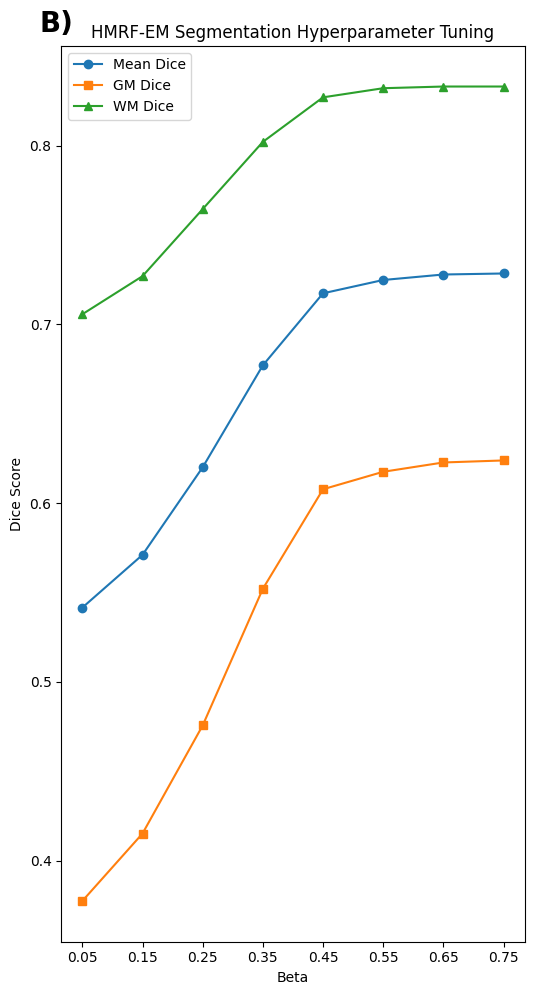

In [ ]:
import matplotlib.pyplot as plt




betas = list(dice_scores.keys())
means = [dice_scores[beta]['mean'] for beta in betas]
gm_scores = [dice_scores[beta]['label=2'] for beta in betas]
wm_scores = [dice_scores[beta]['label=1'] for beta in betas]

plt.figure(figsize=(6, 10))
plt.plot(betas, means, marker='o', label='Mean Dice')
plt.plot(betas, gm_scores, marker='s', label='GM Dice')
plt.plot(betas, wm_scores, marker='^', label='WM Dice')
plt.xlabel('Beta')
plt.ylabel('Dice Score')
plt.title('HMRF-EM Segmentation Hyperparameter Tuning')
plt.legend()
plt.text(-0.01, 1.04, "B)", transform=plt.gca().transAxes, fontsize= 20, fontweight='bold', va='top', ha='center')
plt.tight_layout()

# Format x-axis tick labels to 2 decimals
plt.gca().set_xticks(betas)
plt.gca().set_xticklabels([f"{float(b):.2f}" for b in betas])
plt.savefig("figures/HMRF_EM_Segmentation_Hyperparameter_Tuning.svg", dpi= 1000)
plt.show()

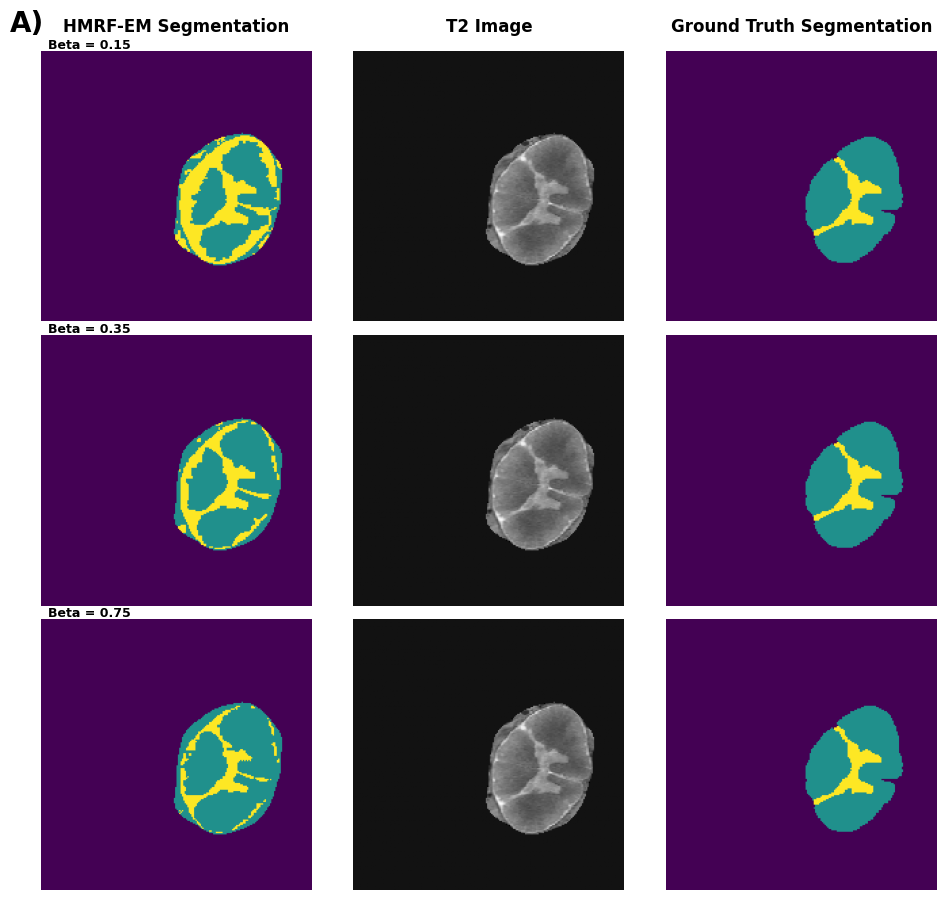

In [517]:
# Pick only 2nd, 4th, and last keys
keys = list(Segment_dict_prelabel.keys())
selected_keys = [keys[1], keys[3], keys[-1]]  # 0-based indexing

z = 30
fig, axes = plt.subplots(len(selected_keys), 3, figsize=(10, 3 * len(selected_keys)))
for i, key in enumerate(selected_keys):
    beta = key
    segs = Segment_dict_prelabel[beta]

    im = axes[i, 0].imshow(segs[1][z, :, :])
    #fig.colorbar(im, ax=axes[i, 0])
    axes[i, 0].axis('off')

    axes[i, 1].imshow(data_labeled_subset_masked[z, :, :], cmap="gray")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(labels_gm_wm_subset[z, :, :])
    axes[i, 2].axis('off')

    
    axes[i,0].text(0.18, 1.02, f"Beta = {float(beta):.2f}", transform=axes[i,0].transAxes,
            fontsize=9, fontweight='bold', va='center', ha='center')
    
 #Text 
axes[0,0].text(0.5, 1.12, "HMRF-EM Segmentation", transform=axes[0,0].transAxes, fontsize=12, fontweight='bold', va='top', ha='center')
axes[0,1].text(0.5, 1.12, "T2 Image", transform=axes[0,1].transAxes, fontsize=12, fontweight='bold', va='top', ha='center')
axes[0,2].text(0.5, 1.12, "Ground Truth Segmentation", transform=axes[0,2].transAxes, fontsize=12, fontweight='bold', va='top', ha='center')

axes[0,0].text(-0.05, 1.15, "A)", transform=axes[0,0].transAxes, fontsize= 20, fontweight='bold', va='top', ha='center')
plt.tight_layout()
plt.subplots_adjust(wspace= .001, hspace= .05)

plt.savefig("figures/HMRF_EM_Segmentation_2class_selected_betas.svg", dpi=1000)


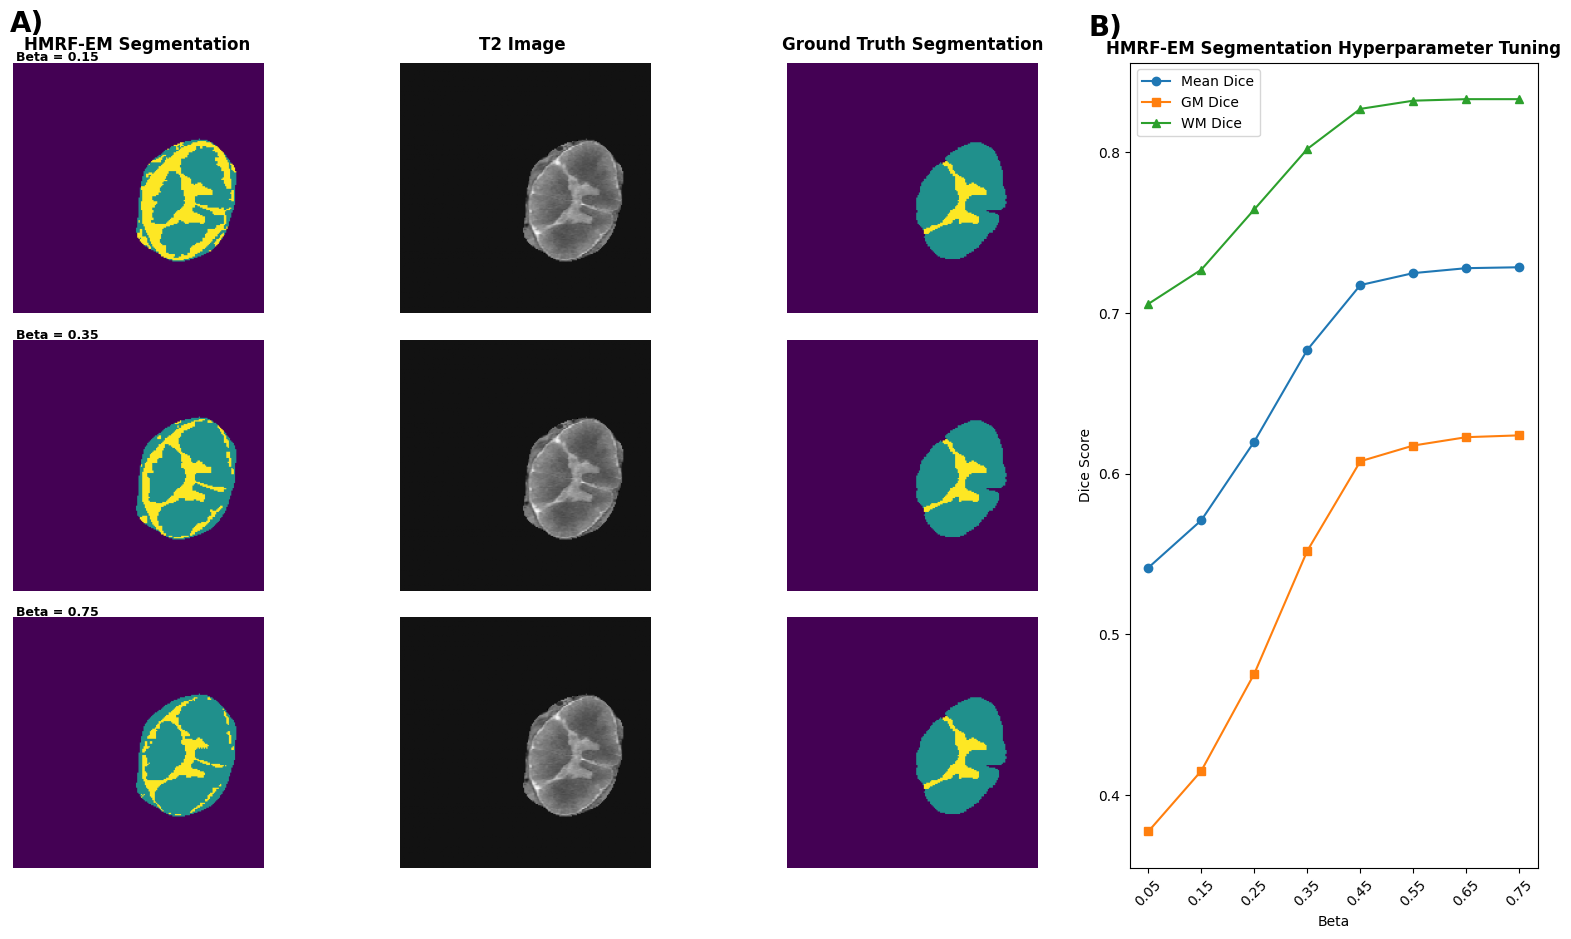

In [619]:
import matplotlib.gridspec as gridspec

# Prepare the figure with 3 rows and 4 columns (last column for Dice plot)
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(len(selected_keys), 4, width_ratios=[1, 1, 1, 1.2])

for i, key in enumerate(selected_keys):
    beta = key
    segs = Segment_dict_prelabel[beta]

    ax0 = fig.add_subplot(gs[i, 0])
    ax0.imshow(segs[1][z, :, :])
    ax0.axis('off')
    ax0.text(0.18, 1.02, f"Beta = {float(beta):.2f}", transform=ax0.transAxes,
             fontsize=9, fontweight='bold', va='center', ha='center')
    if i == 0:
        ax0.text(-0.01, 1.21, "A)", transform=ax0.transAxes,
                 fontsize=20, fontweight='bold', va='top', ha='left')

    ax1 = fig.add_subplot(gs[i, 1])
    ax1.imshow(data_labeled_subset_masked[z, :, :], cmap="gray")
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[i, 2])
    ax2.imshow(labels_gm_wm_subset[z, :, :])
    ax2.axis('off')

# Add Dice score plot in the last column, spanning all rows
ax3 = fig.add_subplot(gs[:, 3])
ax3.plot(betas, means, marker='o', label='Mean Dice')
ax3.plot(betas, gm_scores, marker='s', label='GM Dice')
ax3.plot(betas, wm_scores, marker='^', label='WM Dice')
ax3.set_xlabel('Beta')
ax3.set_ylabel('Dice Score')
ax3.set_title('HMRF-EM Segmentation Hyperparameter Tuning', fontweight = 'bold', fontsize = 12)
ax3.legend()
ax3.set_xticks(betas)
ax3.set_xticklabels([f"{float(b):.2f}" for b in betas], rotation=45)
ax3.text(-0.1, 1.06, "B)", transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# Add column titles
fig.text(0.115, .908, "HMRF-EM Segmentation", fontsize=12, fontweight='bold', va='top', ha='center')
fig.text(0.356, .908, "T2 Image", fontsize=12, fontweight='bold', va='top', ha='center')
fig.text(0.6, .908, "Ground Truth Segmentation", fontsize=12, fontweight='bold', va='top', ha='center')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("figures/combined_HMRF_segmentation_and_dice.svg", dpi=300)
plt.show()


# Combine Image of K-means and HMRF-EM Models

### K_means and HMRF-EM Segmentation (With raw images also)

In [ ]:
import svgutils.transform as sg
import sys 

#create new SVG figure
fig = sg.SVGFigure("14cm", "14cm")


path1 = "figures/k_means_segmentation_raw_and_processed.svg"
path2 = "figures/HMRF_EM_Segmentation_2class.svg"
# load matpotlib-generated figures
fig1 = sg.fromfile(path1)
fig2 = sg.fromfile(path2)

# get the plot objects
plot1 = fig1.getroot()
plot2 = fig2.getroot()

plot2.moveto(600, 28,scale_x = 0.5)

# add text labels
#txt1 = sg.TextElement(25,20, "A", size=12, weight="bold")
txt2 = sg.TextElement(600,25, "C)", size=20, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2])
fig.append([txt2])
# fig.append([txt1, txt2])

fig.save("figures/combined_figure.svg")


### HyperParameter Tuning of HMRF-EM Model

In [ ]:
######### HyperParameter Tuning of HMRF-EM Model ##################

#create new SVG figure
fig = sg.SVGFigure("6cm", "6cm")


path1 = "figures/HMRF_EM_Segmentation_2class_selected_betas.svg"
path2 = "figures/HMRF_EM_Segmentation_Hyperparameter_Tuning.svg"
# load matpotlib-generated figures
fig1 = sg.fromfile(path1)
fig2 = sg.fromfile(path2)

# get the plot objects
plot1 = fig1.getroot()
plot2 = fig2.getroot()

scale_factor = 0.5
plot1.moveto(0, 0, scale_x= .8 * scale_factor, scale_y= .8 * scale_factor)

plot2.moveto(550*scale_factor,0, scale_y = .75 * scale_factor, scale_x= 1 * scale_factor)

# add text labels
#txt1 = sg.TextElement(25,20, "A", size=12, weight="bold")
#txt2 = sg.TextElement(600,25, "C)", size=20, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2])
#fig.append([txt2])
# fig.append([txt1, txt2])

fig.save("figures/HMRF_EM_figure.svg")

### K_means and HMRF-EM Segmentation

In [690]:
import re
import svgutils.transform as sg

def to_cm(s: str) -> float:
    s = s.strip()
    m = re.match(r'^([0-9.+-eE]+)\s*([a-z%]*)$', s)
    if not m:
        raise ValueError(f"Unrecognized size: {s}")
    val, unit = float(m.group(1)), m.group(2).lower()
    if unit in ("", "px"):      # assume SVG 96 px = 1 in
        return val * (2.54 / 96.0)
    if unit == "pt":            # 72 pt = 1 in
        return val * (2.54 / 72.0)
    if unit == "in":
        return val * 2.54
    if unit == "mm":
        return val * 0.1
    if unit == "cm":
        return val
    raise ValueError(f"Unsupported unit: {unit}")

# Canvas for the combined figure
fig = sg.SVGFigure("14cm", "14cm")

path1 = "figures/k_means_segmentation_raw_and_processed.svg"
path2 = "figures/HMRF_EM_Segmentation_2class_only_segmentations.svg"

fig1 = sg.fromfile(path1)
fig2 = sg.fromfile(path2)

plot1 = fig1.getroot()
plot2 = fig2.getroot()

# Read original sizes and convert to cm
w1_s, h1_s = fig1.get_size()   # e.g., ('576pt','432pt')
w2_s, h2_s = fig2.get_size()
w1, h1 = to_cm(w1_s), to_cm(h1_s)
w2, h2 = to_cm(w2_s), to_cm(h2_s)

# Make heights equal
target_h = min(h1, h2)
scale1 = target_h / h1 if h1 > 0 else 1.0
scale2 = target_h / h2 if h2 > 0 else 1.0

# Position: put plot2 to the right of plot1 with a small gap
gap_cm = 0.5
x2_cm = w1 * scale1 + gap_cm

scale_everything = .6

plot1.moveto(0, 0, scale_x=scale1 *scale_everything, scale_y=scale1* scale_everything)
plot2.moveto(350, 0, scale_x=scale2 * scale_everything, scale_y=scale2 * scale_everything)

fig.append([plot1, plot2])
fig.save("figures/K_means_plus_HMRF_EM_figure.svg")


# Test Random Stuff

In [5]:
# Load the pickle file
with open('data/Segment/DIPY_Seg_nclass2Test.pkl', 'rb') as f:
    Segment_dict = pickle.load(f)
    #print(loaded_dict)

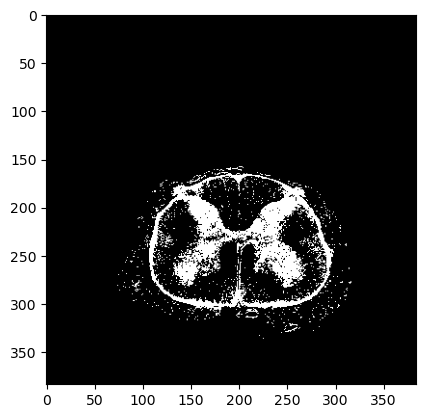

In [ ]:
gm_mask = np.where(final_segmentation == 3, True, False)

plt.imshow(np.rot90(gm_mask[:,:, 10]),cmap='gray')


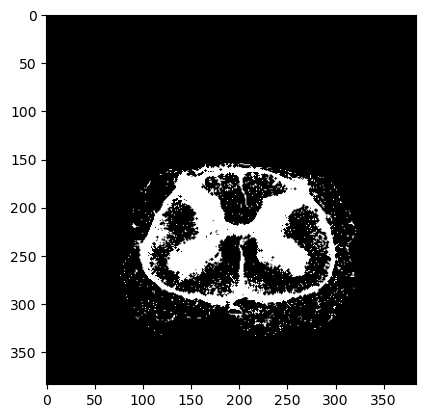

In [ ]:
from scipy import ndimage
gm_mask_dilated = ndimage.binary_closing(gm_mask, iterations= 1)


plt.imshow(np.rot90(gm_mask_dilated[:,:, 40]),cmap='gray')


Text(0.5, 1.0, 'Coronal')

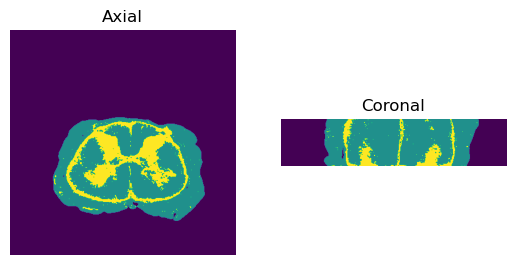

In [ ]:
fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
img_ax = np.rot90(final_segmentation[:,:, 60])
imgplot = plt.imshow(img_ax)
a.axis('off')
a.set_title('Axial')

a = fig.add_subplot(1, 2, 2)
img_cor = np.rot90(final_segmentation[:, 110, :])
imgplot = plt.imshow(img_cor)
a.axis('off')
a.set_title('Coronal')